In [5]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Deep Learning & NLP
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

# Machine Learning
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_recall_fscore_support
)

# Utility
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
Device: cuda


In [6]:
import re


def preprocess_text(text):
    text = str(text).lower()  # Ensure text is string and convert to lowercase
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Remove RT
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


# LOAD PROCESSED DATA

# Consistent data loading
X_train = np.load('processed_data/X_train.npy', allow_pickle=True)
X_val = np.load('processed_data/X_val.npy', allow_pickle=True)
X_test = np.load('processed_data/X_test.npy', allow_pickle=True)
y_train = np.load('processed_data/y_train.npy', allow_pickle=True)
y_val = np.load('processed_data/y_val.npy', allow_pickle=True)
y_test = np.load('processed_data/y_test.npy', allow_pickle=True)

with open('processed_data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

with open('processed_data/preprocessing_config.pkl', 'rb') as f:
    preprocessing_config = pickle.load(f)

class_weight_dict = metadata['class_weights']
label_mapping = metadata['label_mapping']
preprocess_text = preprocessing_config['preprocess_function'] # This line will now succeed

print(f"\nData loaded successfully")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"\nClass Weights: {class_weight_dict}")


Data loaded successfully
Train: 4510, Val: 967, Test: 967

Class Weights: {0: np.float64(0.45031446540880504), 1: np.float64(2.930422919508868), 2: np.float64(2.2826780021253987)}


In [7]:
# LOAD TOKENIZER

MODEL_NAME = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer loaded: {MODEL_NAME}")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer loaded: indolem/indobertweet-base-uncased


In [8]:
# CUSTOM DATASET CLASS

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

MAX_LEN = 128
BATCH_SIZE = 16

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, MAX_LEN)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"\nConfiguration:")
print(f"  Max Length: {MAX_LEN}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Train Batches: {len(train_loader)}")
print(f"  Val Batches: {len(val_loader)}")
print(f"  Test Batches: {len(test_loader)}")


Configuration:
  Max Length: 128
  Batch Size: 16
  Train Batches: 282
  Val Batches: 61
  Test Batches: 61


In [9]:
# HYBRID MODEL ARCHITECTURE

class HybridBERTBiLSTM(nn.Module):
    def __init__(self, bert_model_name, lstm_hidden_size=128, num_classes=3, dropout=0.3):
        super(HybridBERTBiLSTM, self).__init__()

        # BERT Layer
        self.bert = AutoModel.from_pretrained(bert_model_name)

        # Optional: Freeze BERT (uncomment to freeze)
        # for param in self.bert.parameters():
        #     param.requires_grad = False

        self.bert_hidden_size = self.bert.config.hidden_size

        # Bi-LSTM Layer
        self.lstm = nn.LSTM(
            input_size=self.bert_hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(lstm_hidden_size * 2, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask):
        # BERT Embeddings
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # last_hidden_state shape: (batch_size, seq_length, hidden_size)
        sequence_output = bert_output.last_hidden_state

        # Bi-LSTM
        lstm_output, (hidden, cell) = self.lstm(sequence_output)

        # Concatenate forward and backward hidden states
        hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        # Dropout
        hidden_concat = self.dropout(hidden_concat)

        # Fully Connected Layers
        out = self.fc1(hidden_concat)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

# Initialize model
model = HybridBERTBiLSTM(
    bert_model_name=MODEL_NAME,
    lstm_hidden_size=128,
    num_classes=3,
    dropout=0.3
)

model.to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_parameters(model)
print(f"\nModel built successfully!")
print(f"Trainable parameters: {trainable_params:,}")

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]


Model built successfully!
Trainable parameters: 111,906,307


In [10]:
# TRAINING CONFIGURATION

EPOCHS = 5
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Weighted loss function
class_weights_tensor = torch.tensor(
    list(class_weight_dict.values()),
    dtype=torch.float
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print(f"\nTraining Setup:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Optimizer: AdamW (weight_decay=0.01)")
print(f"  Scheduler: Linear warmup")
print(f"  Loss: Weighted CrossEntropyLoss")
print(f"  Class Weights: {class_weight_dict}")


Training Setup:
  Epochs: 5
  Learning Rate: 2e-05
  Optimizer: AdamW (weight_decay=0.01)
  Scheduler: Linear warmup
  Loss: Weighted CrossEntropyLoss
  Class Weights: {0: np.float64(0.45031446540880504), 1: np.float64(2.930422919508868), 2: np.float64(2.2826780021253987)}


In [11]:
# TRAINING FUNCTIONS

def train_epoch(model, data_loader, criterion, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0
    total = 0

    progress_bar = tqdm(data_loader, desc='Training')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total += labels.size(0)

        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': loss.item(), 'acc': correct_predictions/total})

    return correct_predictions / total, np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total += labels.size(0)

            losses.append(loss.item())

    return correct_predictions / total, np.mean(losses)

In [12]:
# TRAINING LOOP

# FIXED: Consistent output paths
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

best_accuracy = 0

print("\nStarting training...\n")

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 80)

    train_acc, train_loss = train_epoch(
        model, train_loader, criterion, optimizer, device, scheduler
    )
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

    val_acc, val_loss = eval_model(model, val_loader, criterion, device)
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'models/hybrid_best_model.bin')
        best_accuracy = val_acc
        print(f'Best model saved (Val Acc: {best_accuracy:.4f})')

    print()

print("Training completed!")

# Save history
with open('results/hybrid_history.pkl', 'wb') as f:
    pickle.dump(history, f)


Starting training...

Epoch 1/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/282 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Training: 100%|██████████| 282/282 [01:39<00:00,  2.84it/s, loss=0.674, acc=0.659]


Train Loss: 0.9678 | Train Acc: 0.6585


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  9.01it/s]


Val Loss: 0.7376 | Val Acc: 0.8428
Best model saved (Val Acc: 0.8428)

Epoch 2/5
--------------------------------------------------------------------------------


Training: 100%|██████████| 282/282 [01:41<00:00,  2.79it/s, loss=0.674, acc=0.884]


Train Loss: 0.6186 | Train Acc: 0.8843


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  9.20it/s]


Val Loss: 0.5285 | Val Acc: 0.8790
Best model saved (Val Acc: 0.8790)

Epoch 3/5
--------------------------------------------------------------------------------


Training: 100%|██████████| 282/282 [01:41<00:00,  2.78it/s, loss=0.164, acc=0.934]


Train Loss: 0.3677 | Train Acc: 0.9344


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  9.17it/s]


Val Loss: 0.4935 | Val Acc: 0.9038
Best model saved (Val Acc: 0.9038)

Epoch 4/5
--------------------------------------------------------------------------------


Training: 100%|██████████| 282/282 [01:41<00:00,  2.79it/s, loss=1.01, acc=0.963]


Train Loss: 0.2323 | Train Acc: 0.9625


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  9.14it/s]


Val Loss: 0.5771 | Val Acc: 0.9193
Best model saved (Val Acc: 0.9193)

Epoch 5/5
--------------------------------------------------------------------------------


Training: 100%|██████████| 282/282 [01:41<00:00,  2.79it/s, loss=0.0745, acc=0.98]


Train Loss: 0.1558 | Train Acc: 0.9803


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  9.09it/s]

Val Loss: 0.5544 | Val Acc: 0.9131

Training completed!


Training history saved


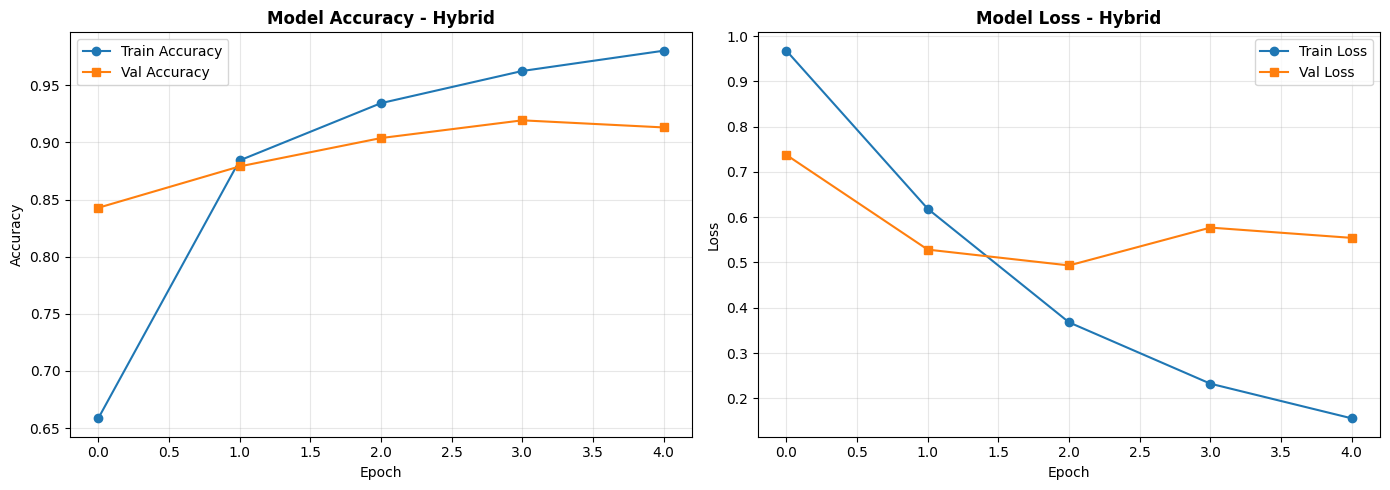

In [13]:
# TRAINING VISUALIZATION

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[0].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[0].set_title('Model Accuracy - Hybrid', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_loss'], label='Train Loss', marker='o')
axes[1].plot(history['val_loss'], label='Val Loss', marker='s')
axes[1].set_title('Model Loss - Hybrid', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/hybrid_training_history.png', dpi=300, bbox_inches='tight')
print("Training history saved")
plt.show()

In [14]:
# EVALUATION ON TEST SET

# Load best model
model.load_state_dict(torch.load('models/hybrid_best_model.bin'))

test_acc, test_loss = eval_model(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

# Get predictions - FIXED: Include probabilities
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    pred_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Predicting'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            pred_probs.extend(probs.cpu().numpy())

    return np.array(predictions), np.array(true_labels), np.array(pred_probs)

y_pred, y_true, y_pred_probs = get_predictions(model, test_loader, device)

# Save predictions
np.save('results/hybrid_predictions.npy', y_pred)
np.save('results/hybrid_pred_probs.npy', y_pred_probs)

Evaluating: 100%|██████████| 61/61 [00:06<00:00,  9.17it/s]



Test Results:
  Test Loss: 0.5610
  Test Accuracy: 0.9090


Predicting: 100%|██████████| 61/61 [00:06<00:00,  9.13it/s]


In [15]:
# DETAILED METRICS

label_names = ['Negative', 'Neutral', 'Positive']
report = classification_report(y_true, y_pred, target_names=label_names, digits=4)
print("\n" + report)

# FIXED: Add F1 scores
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nAdditional Metrics:")
print(f"  Macro F1-Score: {macro_f1:.4f}")
print(f"  Weighted F1-Score: {weighted_f1:.4f}")

# FIXED: Add per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1, 2]
)

print(f"\nPer-Class Performance:")
print("-" * 60)
for i, label in enumerate(label_names):
    print(f"{label:10s} | P: {precision[i]:.4f} | R: {recall[i]:.4f} | "
          f"F1: {f1[i]:.4f} | Support: {support[i]}")


              precision    recall  f1-score   support

    Negative     0.9483    0.9483    0.9483       716
     Neutral     0.7879    0.7091    0.7464       110
    Positive     0.8026    0.8652    0.8328       141

    accuracy                         0.9090       967
   macro avg     0.8463    0.8409    0.8425       967
weighted avg     0.9088    0.9090    0.9085       967


Additional Metrics:
  Macro F1-Score: 0.8425
  Weighted F1-Score: 0.9085

Per-Class Performance:
------------------------------------------------------------
Negative   | P: 0.9483 | R: 0.9483 | F1: 0.9483 | Support: 716
Neutral    | P: 0.7879 | R: 0.7091 | F1: 0.7464 | Support: 110
Positive   | P: 0.8026 | R: 0.8652 | F1: 0.8328 | Support: 141


Confusion matrix saved


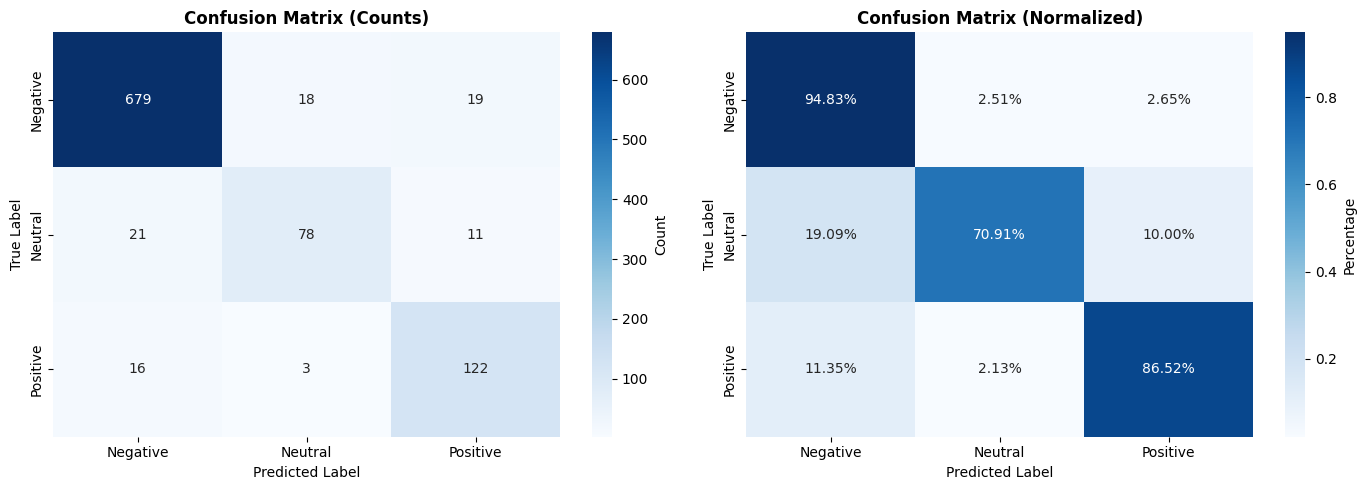

In [16]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred)

# FIXED: Add normalized version
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('results/hybrid_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved")
plt.show()

In [17]:
# ERROR ANALYSIS

misclassified_idx = np.where(y_pred != y_true)[0]
print(f"\nTotal misclassified: {len(misclassified_idx)} / {len(y_true)} "
      f"({len(misclassified_idx)/len(y_true)*100:.2f}%)")

print("\nSample Misclassifications:")
print("-" * 80)
for i, idx in enumerate(misclassified_idx[:5]):
    true_label = label_names[y_true[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]]

    print(f"\n{i+1}. Text: {X_test[idx][:100]}...")
    print(f"   True: {true_label} | Predicted: {pred_label} | Confidence: {confidence:.4f}")


Total misclassified: 88 / 967 (9.10%)

Sample Misclassifications:
--------------------------------------------------------------------------------

1. Text: seandainya bangsa indonesia itutahu leluhur itu agamanya apa dan dapat di pastikan indonesia sudah m...
   True: Negative | Predicted: Positive | Confidence: 0.9700

2. Text: pak guru gembul islam sejati di indonesia menurut saya dari ntt semakin banyak orang beribadah pasti...
   True: Negative | Predicted: Positive | Confidence: 0.9613

3. Text: usir semua islam di papua jangan ada mesjid mushola dan oesantren di papya papua merdeka...
   True: Neutral | Predicted: Negative | Confidence: 0.9664

4. Text: semoga gembul jadi anggota dpr karena untuk saat ini hanya dia yg berani kritik dengan data dan pali...
   True: Negative | Predicted: Positive | Confidence: 0.9734

5. Text: memang uud hrs benar ditegakan tanpa terkecuali tangkap pembuat rusuh...
   True: Negative | Predicted: Positive | Confidence: 0.9711


In [18]:
# PREDICTION FUNCTION

def predict_sentiment(text, model, tokenizer, preprocess_func, device, max_len=128):
    """Prediksi sentimen dari teks input"""
    model.eval()

    # FIXED: Use unified preprocessing
    text_clean = preprocess_func(text)

    encoding = tokenizer.encode_plus(
        text_clean,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, dim=1)

    labels = ['Negative', 'Neutral', 'Positive']
    return labels[predicted.item()], confidence.item(), probs[0].cpu().numpy()

# Test predictions
test_texts = [
    "Keren banget! Sangat informatif dan bermanfaat",
    "Biasa aja sih, tidak ada yang spesial",
    "Mengecewakan sekali, sangat buruk"
]

print("\nTest Predictions:")
print("="*80)
for text in test_texts:
    sentiment, conf, probs = predict_sentiment(text, model, tokenizer, preprocess_text, device)
    print(f"\nText: {text}")
    print(f"Prediction: {sentiment} (Confidence: {conf:.4f})")
    print(f"Probabilities: Neg={probs[0]:.4f}, Neu={probs[1]:.4f}, Pos={probs[2]:.4f}")


Test Predictions:

Text: Keren banget! Sangat informatif dan bermanfaat
Prediction: Positive (Confidence: 0.9719)
Probabilities: Neg=0.0136, Neu=0.0145, Pos=0.9719

Text: Biasa aja sih, tidak ada yang spesial
Prediction: Neutral (Confidence: 0.9050)
Probabilities: Neg=0.0509, Neu=0.9050, Pos=0.0441

Text: Mengecewakan sekali, sangat buruk
Prediction: Negative (Confidence: 0.9640)
Probabilities: Neg=0.9640, Neu=0.0197, Pos=0.0163


In [19]:
# SAVE MODEL & SUMMARY

# Save model
torch.save(model.state_dict(), 'models/hybrid_model.bin')
print(" Model saved: models/hybrid_model.bin")

# FIXED: Save summary
summary = {
    'model_name': 'Hybrid (IndoBERTweet + Bi-LSTM)',
    'bert_model': MODEL_NAME,
    'lstm_hidden_size': 128,
    'parameters': trainable_params,
    'max_len': MAX_LEN,
    'batch_size': BATCH_SIZE,
    'epochs_trained': EPOCHS,
    'learning_rate': LEARNING_RATE,
    'best_val_accuracy': float(best_accuracy),
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'macro_f1': float(macro_f1),
    'weighted_f1': float(weighted_f1),
    'per_class_f1': {
        'negative': float(f1[0]),
        'neutral': float(f1[1]),
        'positive': float(f1[2])
    }
}

with open('results/hybrid_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)

print("Summary saved: results/hybrid_summary.pkl")

print("\nHybrid Model Summary:")
print("-" * 80)
for key, value in summary.items():
    if key != 'per_class_f1':
        print(f"{key:20s}: {value}")

 Model saved: models/hybrid_model.bin
Summary saved: results/hybrid_summary.pkl

Hybrid Model Summary:
--------------------------------------------------------------------------------
model_name          : Hybrid (IndoBERTweet + Bi-LSTM)
bert_model          : indolem/indobertweet-base-uncased
lstm_hidden_size    : 128
parameters          : 111906307
max_len             : 128
batch_size          : 16
epochs_trained      : 5
learning_rate       : 2e-05
best_val_accuracy   : 0.9193381592554292
test_accuracy       : 0.9089968976215098
test_loss           : 0.5610189584435009
macro_f1            : 0.842500003573137
weighted_f1         : 0.908505748065913
